## Slow Feature Analysis

### Exerecise 2: SFA on a high-dimensional correlated signal

Generate a 1D-image of length L = 10'000 pixels with the same power spectral density as above, but with $\epsilon$ = 0.04.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
sns.set(palette='Set2')

In [2]:
def lp_signal(rand_signal, epsilon, sample_period):
    
    fft_rand_signal = np.fft.fft( rand_signal )
    frq_rand_signal = np.fft.fftfreq( rand_signal.size, sample_period )
    
    filter_low = np.sqrt(np.exp(- frq_rand_signal**2 / (2*epsilon)))
    filter_low = filter_low / np.sum(filter_low)
   
    filter_fft_rand_signal = fft_rand_signal*filter_low
    filter_rand_signal = np.real(np.fft.ifft( filter_fft_rand_signal ))
    return filter_rand_signal;

In [3]:
L = 10000
e = 0.04 #tau=5
image = lp_signal(np.random.random(L), e, 1)

Extract a time-dependent receptive field input by sliding a window of length l=100 pixels across the entire image. The portion of the image that is covered by the window represents the current input to the visual cell. Starting from the left, the window is shifted to the right by one pixel in each time step. The width of the window determines the dimensionality of the receptive field input. Generate a matrix X containing the complete receptive field input recorded while the window is sliding over the image. It should have a dimensionality of 100x9900: 100 variables
describing the current image, each with 9900 samples over time. Make sure that the average input to each pixel of the receptive field is zero, i.e. each row of the matrix should have zero-mean.

In [4]:
l = 100
X = []
for i in range(L - l):
    x = image[i:i+l]
    X.append(x);
    
X = np.array(X).T
m = np.mean(X, axis=1) 
m = np.expand_dims(m, axis=1)
X -= m #zero mean constraint
std = np.expand_dims(np.std(X, axis=1), axis=1)
X = X/std #unit variance constraint

Compute the covariance matrix C of the high-dimensional signal X as well as the matrix C of the second moments of its temporal derivative X. Solve the Generalised Eigenvalue Problem:

In [5]:
dt = 1
C = np.cov(X)
dX = np.diff(X)/dt
dC = np.dot(dX, dX.T)/(L-1)
values, W = sp.linalg.eig(dC, C)
values = values.real

Sort the eigenvectors according to the magnitude of the corresponding eigenvalues. Extract the eigenvectors that correspond to the five slowest SFA-components and plot them:

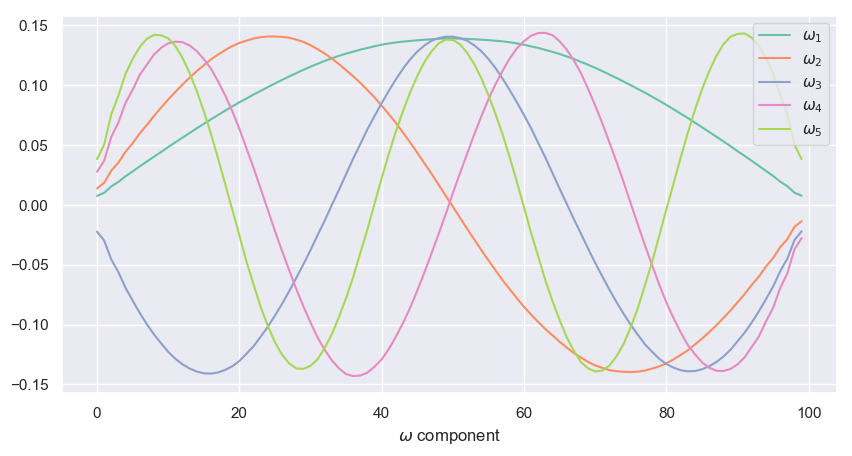

In [6]:
idx = np.argsort(values)[0:5] #indexes of the 5 slowest components
Wslow = np.array([W[:, i] for i in idx]) #first 5 eigenvectors

plt.figure(figsize=(10,5), dpi=100)
[plt.plot(Wslow[i,:], label=r'$\omega_{}$'.format(i+1)) for i in range(5)];
plt.xlabel(r'$\omega$ component');
plt.legend(loc=1);

In [7]:
sort_idx = np.argsort(values)
Wsort = np.full_like(W, 0)
for i, idx in enumerate(sort_idx):
    Wsort[:, i] = (W[:,idx]) #sorted eigenvector matrix

How do you interpret the shape of the eigenvectors? In which way do the characteristics of the eigenvectors correspond to the intentions underlying SFA? Discuss the properties of the eigenvectors at the boundaries of the receptive fields (Hint: think about how these boundaries react when sliding over edges in the image). How does the shape of these eigenvectors relate to the structure of the receptive fields in primary visual cortex V1?

As a last step we will use the extracted SFA-eigenvectors W to project the original signal (which was generated in the pixel-basis) onto the new SFA-basis. Determine the signal in the SFA-basis Y by multiplying the eigenvectors with the signal ($Y = W^{T}X$). Plot the five slowest components of the SFA-signal into a single graph (you may add a y-offset to each component so they don't overlay). Did the Slow Feature Analysis succeed?

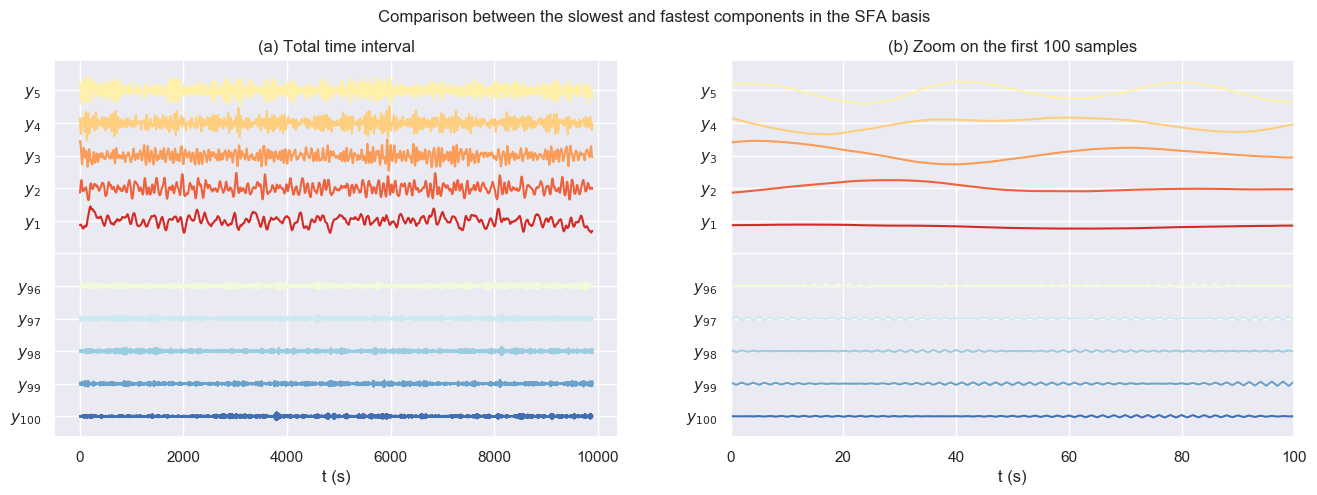

In [16]:
Y = np.dot(Wsort.T, X) #signal in the SFA-basis

div = sns.color_palette("RdYlBu", 10)
sns.set_palette(div)
#seq_col_brew = sns.color_palette("Spectral", 10)
#sns.set_palette(seq_col_brew)#set diverging palette

f = plt.figure(figsize=(16,5), dpi=100)
plt.suptitle('Comparison between the slowest and fastest components in the SFA basis')

plt.subplot(121)
for idx in range(5):
    y = np.array(Y[idx, :])  + (idx+1)*10
    plt.plot(y, label=r'$y_{}$'.format(i+1));

for i, idx in enumerate(range(95,100)):
    y = np.array(Y[idx, :])  - (i+1)*10
    plt.plot(y, label=r'$y_{}$'.format(i+1));
    
plt.xlabel('t (s)');
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], [r'$y_{100}$', r'$y_{99}$', r'$y_{98}$', r'$y_{97}$', r'$y_{96}$','', r'$y_1$', r'$y_2$', r'$y_3$', r'$y_4$', r'$y_5$']);
plt.title('(a) Total time interval')

plt.subplot(122)

for idx in range(5):
    y = np.array(Y[idx, :])  + (idx+1)*10
    plt.plot(y, label=r'$y_{}$'.format(i+1));


for i, idx in enumerate(range(95,100)):
    y = np.array(Y[idx, :])  - (i+1)*10
    plt.plot(y, label=r'$y_{}$'.format(i+1));
    
plt.xlabel('t (s)')
plt.title('(b) Zoom on the first 100 samples')
plt.xlim(0, 100)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], [r'$y_{100}$', r'$y_{99}$', r'$y_{98}$', r'$y_{97}$', r'$y_{96}$', '', r'$y_1$', r'$y_2$', r'$y_3$', r'$y_4$', r'$y_5$']);
plt.savefig('final_plot.jpg')
plt.show();

From the plot, we can see how the Slow Feature Analysis managed to extract, from the original signal (of 10'000 pixels), the slowest components of signal projected onto the SFA-basis, corresponding to the direction of the first 5 eigenvectors in the sorted eigenvector matrix. 
In the plot, we can see a comparison between the slowest ($y_1$ - $y_5$) and fastest ($y_{96}$ - $y_{100}$) components of the new SFA-signal.